# Extended Modeling #

As noted in the previous baseline modeling notebook, we are approaching the problem as a supervised classification problem. In the previous notebook, we developed a Logistic Regression model for our analysis. The model performed very well as a baseline. This notebook will develop a Random Forest model.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn.model_selection

## 1. Load Cleaned Corpus of Terms ##

In [2]:
clean_reviews_sample = pd.read_csv('/Users/dwalkerpage/Documents/Data_Science/Springboard/Projects/springboard/Capstone_Projects/Capstone_Project_1/Capstone_Project_1_Data/clean_reviews_sample.csv')

In [3]:
clean_reviews_sample.head()

,Unnamed: 0,business_id,stars,text,sentiment_label
0,0,ja01cHy1xqUB9DQ1r1OYKQ,5.0,great place awesome atmosphere attic chard fan...,1.0
1,1,wJY74R0zAgjxvBf-d4gm9g,1.0,fiancé came drinks seated outside wasnt busy w...,0.0
2,2,r1k3JVOrfF4vJJUWJrF8uQ,5.0,ad says everybody loves showmars wholeheartedl...,1.0
3,3,mOMeDQB8NjdBTTzKtikAYg,5.0,great place great atmosphere already second ti...,1.0
4,4,XcQKsEUlh1W0R4iXbTA1Yg,5.0,really perfect little eatery love visiting hap...,1.0


In [4]:
clean_reviews_sample.isnull().values.any()

True

In [5]:
clean_reviews_sample.isnull().sum().sum()

1

In [6]:
clean_reviews_sample.index[clean_reviews_sample['text'].isnull() == True]

Int64Index([294610], dtype='int64')

In [7]:
clean_reviews_sample.iloc[294610]

Unnamed: 0                         294610
business_id        Xsfu3y0Wz-u7TRXQDTP0tQ
stars                                   1
text                                  NaN
sentiment_label                         0
Name: 294610, dtype: object

The text at index 294610 is NaN. After searching, I discovered that this happened during the cleaning of the corpus. The text of the review at index 294610 consisted entirely of stopwords, so the entire review was removed. This was not discovered when I originally cleaned the corpus because the text was simply blank, and was not detected by the method used above to detect null values. However, the pd.read_csv() function, which was used to load the cleaned DataFrame, replaces blank text with NaN values.

The simplest solution will be to simply drop the row, which will still leave us with 999999 samples.

In [8]:
clean_reviews_sample.drop(columns='Unnamed: 0', index=294610, inplace=True)

In [9]:
clean_reviews_sample.head()

,business_id,stars,text,sentiment_label
0,ja01cHy1xqUB9DQ1r1OYKQ,5.0,great place awesome atmosphere attic chard fan...,1.0
1,wJY74R0zAgjxvBf-d4gm9g,1.0,fiancé came drinks seated outside wasnt busy w...,0.0
2,r1k3JVOrfF4vJJUWJrF8uQ,5.0,ad says everybody loves showmars wholeheartedl...,1.0
3,mOMeDQB8NjdBTTzKtikAYg,5.0,great place great atmosphere already second ti...,1.0
4,XcQKsEUlh1W0R4iXbTA1Yg,5.0,really perfect little eatery love visiting hap...,1.0


In [10]:
clean_reviews_sample.shape

(999999, 4)

In [11]:
clean_reviews_sample.isnull().values.any()

False

## 2. Prepare for Vectorization of Review Text ##

Below we will test models using two different vectorizations of the text.

We will use [CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). CountVectorizer() produces a matrix where the columns are all the individual terms in the corpus vocabulary, the rows are individual documents, and the matrix values are the count or frequency with which the term in the column occurs in the document at that row.

We will use [TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). TfidfVectorizer() produces a similar matrix but term frequencies within individual documents are weighted by the frequency with which they occur across all documents in the corpus. Words with a smaller frequency across documents are more discriminative and thus are given greater weight.

See [here](https://www.quora.com/What-is-the-difference-between-TfidfVectorizer-and-CountVectorizer-1) for helpful descriptions of the difference between these two methods for vectorizing.

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [13]:
# Define function to construct x & y values for model construction

def make_xy(clean_reviews_sample, vectorizer=None):  
    '''Make x & y values for model construction'''
    if vectorizer is None:
        vectorizer = CountVectorizer()
    x = vectorizer.fit_transform(clean_reviews_sample.text)
    x = x.tocsc()  # some versions of sklearn return COO format
    y = np.asarray([i for i in clean_reviews_sample['sentiment_label'].values])
    return x, y, vectorizer

## 3. Random Forest Model ##

In [16]:
from collections import OrderedDict
from sklearn.ensemble import RandomForestClassifier

In [17]:
# See here: https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py
''' Ensemble of Three Random Forest Classifiers
Using three different values for 'max_features' parameter
And Using different numbers of estimators
'''

def rf_classifier(x, y):
    # NOTE: Setting the `warm_start` construction parameter to `True` disables
    # support for parallelized ensembles but is necessary for tracking the OOB
    # error trajectory during training.
    # See here: https://scikit-learn.org/stable/glossary.html#term-warm-start
    ensemble_clfs = [
        ("RandomForestClassifier, max_features='sqrt'",
            RandomForestClassifier(warm_start=True, oob_score=True,
                                   max_features="sqrt",
                                   random_state=7)),
        ("RandomForestClassifier, max_features='log2'",
            RandomForestClassifier(warm_start=True, max_features='log2',
                                   oob_score=True,
                                   random_state=7)),
        ("RandomForestClassifier, max_features=None",
            RandomForestClassifier(warm_start=True, max_features=None,
                                   oob_score=True,
                                   random_state=7))
    ]

    # Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
    error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

    # Range of `n_estimators` values to explore.
    min_estimators = 50
    max_estimators = 150

    for label, clf in ensemble_clfs:
        for i in range(min_estimators, max_estimators + 1, 10):
            clf.set_params(n_estimators=i)
            clf.fit(x, y)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - clf.oob_score_
            error_rate[label].append((i, oob_error))
    return error_rate, clf

In [18]:
def plot_error(error_rate, title=None):
    # Generate the "OOB error rate" vs. "n_estimators" plot.
    for label, clf_err in error_rate.items():
        xs, ys = zip(*clf_err)
        plt.plot(xs, ys, label=label)

    plt.xticks(range(50, 151, 10))
    plt.yticks([round(i, 2) for i in np.arange(0.05, 0.5, 0.05)])
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.title(title)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.show()

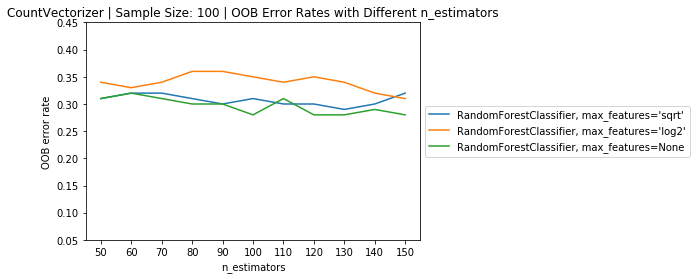

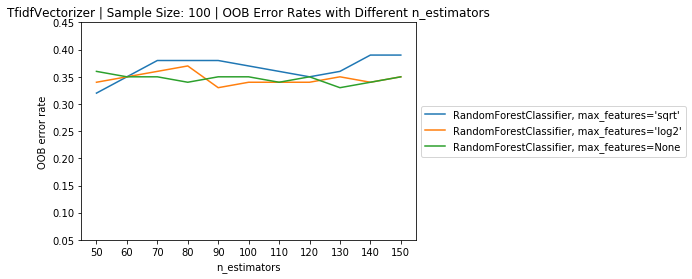

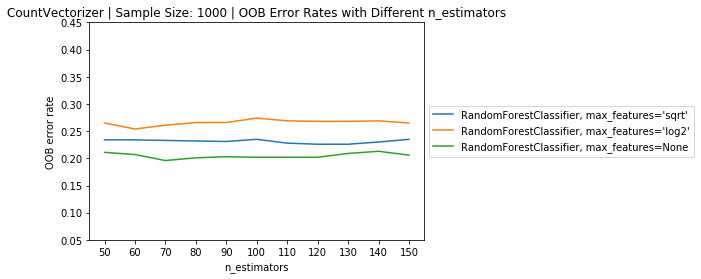

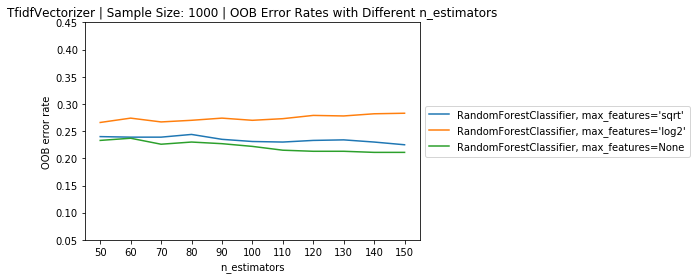

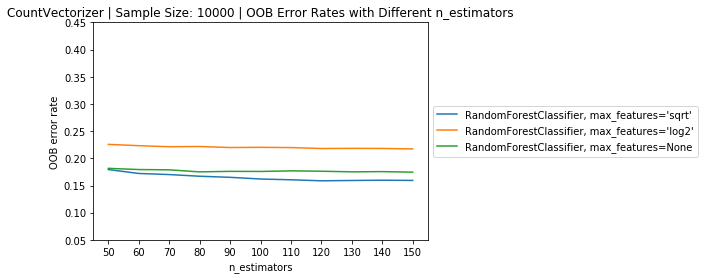

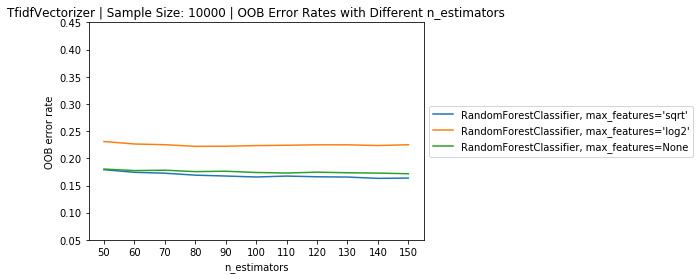

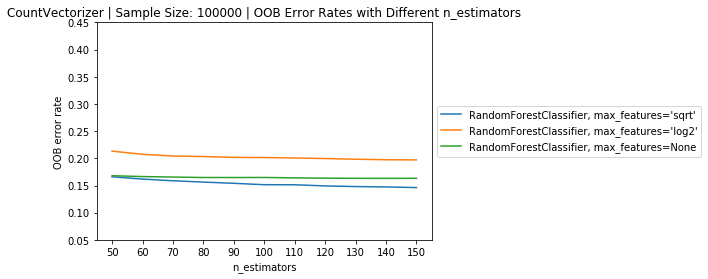

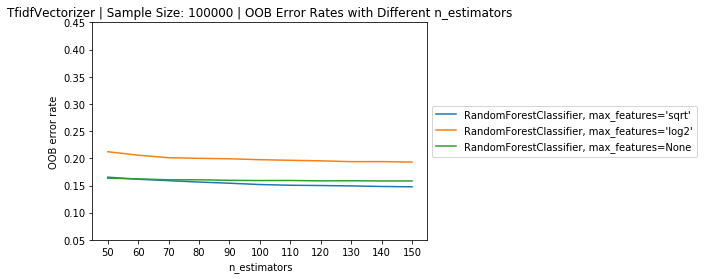

CPU times: user 10h 46min 5s, sys: 1min 38s, total: 10h 47min 44s
Wall time: 10h 46min 41s


In [19]:
%%time

sample_sizes = [100, 1000, 10000, 100000]
vectorizers = [CountVectorizer(), TfidfVectorizer()]

for i in sample_sizes:
    for vect in vectorizers:
        sample = clean_reviews_sample.sample(n=i, random_state=7)
        x, y, v = make_xy(sample, vectorizer=vect)
        error_rate, clf = rf_classifier(x, y)
        plot_error(error_rate, title='{} | Sample Size: {} | OOB Error Rates with Different n_estimators'.format(type(vect).__name__, i))

We have now tried varying (1) the number of samples, (2) the max_features, (3) the type of vectorization, and (4) the number of estimators/trees used in the Random Forest model. 

Based on the above testing, we can see that (1) a larger number of samples increases performance, (2) using all of the features has little if any performance benefit over using the square root of the number of features, (3) using the Tfidf vectorizer produces a slight performance advantage over using CountVectorizer, and (4) using more than 100 estimators/trees produces minimal performance benefit.

Another thing we can try is using both 'gini' and 'entropy' for the 'criterion' parameter.

Next steps include the following:
* Test different values for the criterion parameter on a sample of size 10,000 (since this is much faster than sample of 100,000, but performance is similar, based on graphs above), using both CountVectorizer and TfidfVectorizer.  
* Train model on larger sample, and compute evaluation metrics.
* Analyze the importance of the features (which in my case are word-tokens) for classification. See the sklearn attribute 'feature_importances_'. Remove unimportant features and see how performance changes.
* Once model is trained, perhaps try using on unused data to evaluate performance.

In [20]:
# Take random sample of size 10,000

test10000 = clean_reviews_sample.sample(n=10000, random_state=7)

In [45]:
vectorizers = [CountVectorizer(), TfidfVectorizer()]
criteria = ['gini', 'entropy']

for vect in vectorizers:
    for crit in criteria:
        x, y, v = make_xy(test10000, vectorizer=vect)
        rf_clf = RandomForestClassifier(n_estimators=100, criterion=crit, max_features='sqrt', oob_score=True, random_state=7)
        rf_clf.fit(x, y)
        oob_error = 1 - rf_clf.oob_score_
        print('The OOB Error using the', crit, 'criterion and {} is: {}'.format(type(vect).__name__, oob_error))

The OOB Error using the gini criterion and CountVectorizer is: 0.16200000000000003
The OOB Error using the entropy criterion and CountVectorizer is: 0.1623
The OOB Error using the gini criterion and TfidfVectorizer is: 0.16569999999999996
The OOB Error using the entropy criterion and TfidfVectorizer is: 0.1654


Based on the above testing, we can conclude that our best model will likely having the following properties:
* Vectorizer: CountVectorizer
* n_estimators=100
* criterion='gini'
* max_features='sqrt'

In what follows, we can divide our original large sample data ('clean_reviews_sample') into a training and test set, train a Random Forest model on the training data, and compute various performance metrics (using the sklearn 'classification report') using the test data. It will also be interesting to compare (1) the oob_score of the trained model with (2) its accuracy on the training data and (3) its accuracy on the test data.

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

In [48]:
# Vectorize review text using CountVectorizer

x, y, vect = make_xy(clean_reviews_sample)

In [59]:
# Save vectorizer object for later use
# See here: https://www.kaggle.com/mattwills8/fit-transform-and-save-tfidfvectorizer

import pickle

pickle.dump(vect, open('Yelp_Sentiment_CountVectorizer_for_RF.sav', 'wb'))

# To load vectorizer for future use input:
# variable_name = pickle.load(open('Yelp_Sentiment_CountVectorizer_for_RF.sav', 'rb'))

In [49]:
# Split data into training and test set

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.3, random_state=7, stratify=y)

In [53]:
# Construct Random Forest object

rf_model = RandomForestClassifier(n_estimators=100, criterion='gini', max_features='sqrt', oob_score=True, random_state=7)

In [54]:
%%time
# Fit Random Forest model to training data

rf_model.fit(xtrain, ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=True, random_state=7, verbose=0,
                       warm_start=False)

In [56]:
# OOB Score

print('OOB Score:', rf_model.oob_score_)

OOB Score: 0.8537669339527628


In [55]:
# Accuracy Scores

print('Training Accuracy:', rf_model.score(xtrain, ytrain))
print('Test Accuracy:', rf_model.score(xtest, ytest))

Training Accuracy: 0.9999871428387754
Test Accuracy: 0.8650033333333333


Note, the OOB Score closely approximates the accuracy score for the test data.

In [132]:
# Evaluation Metrics

print('Classification Report for training data:')
print(classification_report(ytrain, rf_model.predict(xtrain)))
print('Classification Report for test data:')
print(classification_report(ytest, rf_model.predict(xtest)))

Classification Report for training data:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    241865
         1.0       1.00      1.00      1.00    458134

    accuracy                           1.00    699999
   macro avg       1.00      1.00      1.00    699999
weighted avg       1.00      1.00      1.00    699999

Classification Report for test data:
              precision    recall  f1-score   support

         0.0       0.90      0.68      0.78    103656
         1.0       0.85      0.96      0.90    196344

    accuracy                           0.87    300000
   macro avg       0.88      0.82      0.84    300000
weighted avg       0.87      0.87      0.86    300000



In [121]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [122]:
# Predict probabilities for AUC_ROC
# See here: https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

probs = rf_model.predict_proba(xtest)

In [127]:
print('ROC AUC:', roc_auc_score(ytest, probs[:,1]))

ROC AUC: 0.9372067000311342


In [128]:
# False Positive and True Positive Rates

fpr, tpr, _ = roc_curve(ytest, probs[:,1])

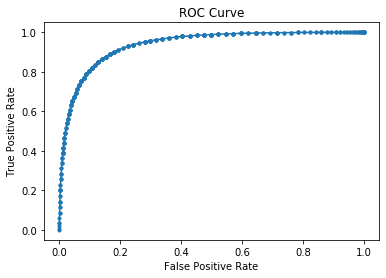

In [131]:
# Plot ROC curve

_ = plt.plot(fpr, tpr, marker='.')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')

plt.show()

In [60]:
# Save final tuned model for later use
# See here: https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/
# And here: https://www.geeksforgeeks.org/saving-a-machine-learning-model/

import pickle

filename = 'RF_Yelp_sentiment_classifier.sav'

pickle.dump(rf_model, open(filename, 'wb'))

# To load model for future use input:
# variable_name = pickle.load(open(filename, 'rb'))

## 4. Inspect Feature Importances ##

In [62]:
# Get feature importances

rf_feat_import = rf_model.feature_importances_

In [83]:
# Get features

features = np.asarray(vect.get_feature_names())

In [86]:
# Construct dictionary with features as keys and corresponding feature importances as values

feature_importances = {}

for feature, importance in zip(features, rf_feat_import):
    feature_importances[feature] = importance

In [98]:
# Construct DataFrame with features and corresponding feature importances side-by-side

feature_importances_df = pd.DataFrame(list(feature_importances.items()), columns=['features', 'feature_importances'], index=np.arange(len(feature_importances)))

In [100]:
# Sort from greatest to least importance

feature_importances_df.sort_values(by=['feature_importances'], ascending=False, inplace=True)

In [113]:
feature_importances_df['scaled_feature_importances'] = feature_importances_df.feature_importances.values * 1000

In [120]:
# Inspect 100 most important features

pd.set_option('display.max_rows', 1000)

print('The Top 100 Most Important Features')
feature_importances_df.head(100)

The Top 100 Most Important Features


,features,feature_importances,scaled_feature_importances
175987,great,0.010794,10.794080
116117,delicious,0.007608,7.608325
275970,ok,0.006531,6.530730
29923,amazing,0.005878,5.877785
434429,worst,0.005373,5.372898
54508,best,0.004940,4.940472
44804,bad,0.004709,4.708643
192652,horrible,0.004201,4.200934
234035,love,0.004019,4.018785
252563,minutes,0.003779,3.778634
